# **PROJET MI201**
## **Several code snippets for the pizza project**

*Arthur Coelho Ruback* </br>
*Gustavo Jodar Soares* </br>
*Matheus Santos Sano* </br>
</br>
The goal of the project is to implement a learning approach capable to identify the toppings of a pizza, using real and synthetic data. The synthetic data is composed by pizza drawings, while the real one is real pizzas.
The data can be downloaded from the page: http://pizzagan.csail.mit.edu/



## 1) Connection to your drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive/')



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## 2) Useful libraries

To do a convolutional neural network (CNN) we use the library "pytorch".

In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn

#!pip install torchmetrics
#from torchmetrics.classification import MultilabelF1Score, MultilabelAccuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if (torch.cuda.is_available()):
  !nvidia-smi

Wed Jan 25 18:43:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#**Real Pizzas Problem**

In this case, the data are no longer pizza drawings (synthetic data), but photos of real pizzas (real data).

## 1) Managing data

### 1.1) Decompress the archive on Gdrive (rather than on your own desktop)
Uncomment the following line to do it.

In [3]:

#!unzip '/content/gdrive/MyDrive/Colab Notebooks/MI201/projet/real_pizzas/pizzaGANsyntheticdata.zip' -d '/content/gdrive/MyDrive/Colab Notebooks/MI201/projet/real_pizzas'


### 1.2) Read data

From the data obtained, we separeted the train and test dataset. In this case, 5896 data were separated only for training, 1474 fro validation and 1843 data only for testing. Moreover, there are 13 possible toppings in a pizza. It is possible to have more than one topping in one pizza.

In [4]:
DATA_DIR =  '/content/gdrive/MyDrive/Colab Notebooks/MI201/projet/real_pizzas/pizzaGANdata'


y_all = np.loadtxt(os.path.join(DATA_DIR, 'imageLabels.txt'))
x_all = np.arange(y_all.shape[0])

print(x_all.shape, y_all.shape)
# Create train, val and test splits
# x_train and x_val only contain image number (not the raw data)

x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)

print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape ,y_test.shape)

(9213,) (9213, 13)
(5896,) (5896, 13)
(1474,) (1474, 13)
(1843,) (1843, 13)


#Display one smple

00046.jpg
/content/gdrive/MyDrive/Colab Notebooks/MI201/projet/real_pizzas/pizzaGANdata/images


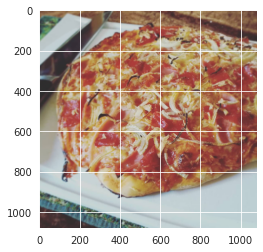

In [5]:
idx = 45

img_name = "{:005d}.jpg".format(idx+1)
print(img_name)
img_path = os.path.join(DATA_DIR, 'images')
print(img_path)
img = Image.open(os.path.join(img_path, img_name))

plt.imshow(img)
plt.show()

### 1.3) Store train images in memory

This should make learning faster.

Also treating images with different shapes, like (224,224,4) and converting them into (224,224,3).

In [6]:
train_data_path=os.path.join(DATA_DIR, '')

img_path = os.path.join(DATA_DIR, 'images')
  
# Test if the numpy file exists
if (os.path.exists(os.path.join(train_data_path, 'img_data_224.npz'))):
  img_data_tensor = np.load(os.path.join(train_data_path, 'img_data_224.npz'))
  img_all = img_data_tensor['img_data']
else:
  img_all = []
    
  for idx in tqdm(x_all):
      img_name = "{:05d}.jpg".format(idx+1)
      x = Image.open(os.path.join(train_data_path, 'images', img_name))
      x_aux = np.array(x.resize((224,224)))
      #converting images with different shapes
      if(x_aux.shape == (224,224,4)):
        x = x_aux[:,:,:3]
        img_all.append(x)
      else:
        img_all.append(x_aux)

  np.savez_compressed(os.path.join(train_data_path,'img_data_224.npz'), img_data=np.array(img_all))

### 3.4) Dataset class

In [7]:
class myDataset(Dataset):
    """Pizza dataset"""
    
    def __init__(self, x_idx, y, img_path='/content/gdrive/MyDrive/Colab Notebooks/MI201/projet/real_pizzas/pizzaGANdata/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data     
    
    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:05d}.jpg".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y
            
    def __len__(self):
        return int(len(self.x_idx))

### 3.5) Data loaders

Image processing and setting global variables for batch size, input size, epochs and learning rate.

In [8]:
batch_size = 25

epochs = 50

input_size = 224

learning_rate = 0.0001

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])
        
kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}

train_data_path=img_path
print(x_train[:10])

img_data_train = [img_all[i] for i in x_train]
img_data_train = np.array(img_data_train)

train_set_raw = myDataset(x_train, y_train, img_path=train_data_path, img_data=img_data_train, transform = train_transform)
train_dataloader = DataLoader(train_set_raw, batch_size=batch_size, shuffle=True, **kwargs)


img_data_val = [img_all[i] for i in x_val]
img_data_val = np.array(img_data_val)

val_set_raw = myDataset(x_val, y_val, img_path=train_data_path, img_data=img_data_val, transform = val_transform)
val_dataloader = DataLoader(val_set_raw, batch_size=batch_size, shuffle=False, **kwargs)

test_data_path=img_data_train
img_data_test = [img_all[i] for i in x_test]
img_data_test = np.array(img_data_test)

test_set_raw = myDataset(x_test, y_test, img_path=train_data_path,img_data=img_data_test, transform = val_transform)
test_dataloader = DataLoader(test_set_raw, batch_size=batch_size, shuffle=False, **kwargs)


[8118 8282 3889 2574 7557 4856 7232 8431   36 7426]


## 4) Learning

In this case, the problem is a multi-label prediction: each image may be characterized by several labels. Therefore, to solve this problem we worked on raw data and build the label predictor directly. </br>
We did a fine tuning of a pre-learned neural network (ResNet), in other words, use the weights of a trained neural network to initialize a new model trained on data from the same images.

### 4.1) Network definition

To do a multi-label prediction, we use a residual neural network (ResNet), remove its last layer and rebuild it defining the desired output. In this new last layer, each neuron represents each topping and has 512 inputs and 1 output, being 0 (the pizza does not have this topping) or 1 (the pizza has this topping). The sigmoid function was implemented precisely to approximate the output values to 0 or 1. We decided to use the ResNet to facilitate the learning, because it is a good pre-learned network capable of identifying features. </br>
Moreover, we use the function Dropout, which droppes out 20% of the nodes in the neural network during training. The Dropout is a solution that we implement to overcome the overfitting problem.

In [9]:
class MultilabelClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.model_wo_fc = nn.Sequential(*(list(self.resnet.children())[:-1]))

        self.topping0 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping1 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping2 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping3 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping4 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping5 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping6 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping7 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping8 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping9 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )
        self.topping10 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping11 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

        self.topping12 = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=1)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)
        return torch.stack([torch.sigmoid(self.topping0(x)),
                            torch.sigmoid(self.topping1(x)),
                            torch.sigmoid(self.topping2(x)),
                            torch.sigmoid(self.topping3(x)),
                            torch.sigmoid(self.topping4(x)),
                            torch.sigmoid(self.topping5(x)),
                            torch.sigmoid(self.topping6(x)),
                            torch.sigmoid(self.topping7(x)),
                            torch.sigmoid(self.topping8(x)),
                            torch.sigmoid(self.topping9(x)),
                            torch.sigmoid(self.topping10(x)),
                            torch.sigmoid(self.topping11(x)),
                            torch.sigmoid(self.topping12(x))
                            ])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultilabelClassifier().to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 4.2) Training function

The training function implemented iterate over the data, bring them into the neural network and compare the current output to the desired output. Then, it calculate the gradient and update the weights in order to approximate the current output and the desired output. </br>
In the definition of the learning parameters, the loss function is a cross entropy loss, while the criterion uses binary cross entropy to ensure the binary output of the neural network. </br>
At each epoch, the losses of training and validation are calculated.

In [11]:
loss_func = nn.CrossEntropyLoss()
criterion = nn.functional.binary_cross_entropy

def training(model,device,lr_rate,epochs,train_loader,val_loader):
  
  num_epochs = epochs
  losses_train = []
  checkpoint_losses_train = []

  losses_val = []
  checkpoint_losses_val = []

  optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
  
  n_total_steps = len(train_loader)

  loss_func = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device),targets.to(device)
      outputs = model(inputs)
      outputs = torch.transpose(outputs, 1, 0)
      outputs = outputs.reshape([len(targets),13])
      outputs = outputs.float()
      
      loss = criterion(outputs.float(), targets.float())
      losses_train.append(loss.item())
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
    for inputs, targets in val_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      outputs = torch.transpose(outputs, 1, 0)
      outputs = outputs.reshape([len(targets),13])
      outputs = outputs.float()

      loss = criterion(outputs.float(), targets.float())
      losses_val.append(loss.item())


    checkpoint_loss_train = torch.tensor(losses_train).mean().item()
    checkpoint_loss_val = torch.tensor(losses_val).mean().item()
        
    checkpoint_losses_train.append(checkpoint_loss_train)
    checkpoint_losses_val.append(checkpoint_loss_val)

    print (f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {checkpoint_loss_train:.4f} | Validation Loss: {checkpoint_loss_val:.4f}')
    if(len(checkpoint_losses_val) > 1 and checkpoint_losses_val[-2] <= checkpoint_losses_val[-1]):
      break

  return checkpoint_losses_train, checkpoint_losses_val

In [12]:
checkpoint_losses = training(model,device,0.0001,epochs,train_dataloader, val_dataloader)

Epoch [1/50], Training Loss: 0.2345 | Validation Loss: 0.1903
Epoch [2/50], Training Loss: 0.2024 | Validation Loss: 0.1872
Epoch [3/50], Training Loss: 0.1867 | Validation Loss: 0.1854
Epoch [4/50], Training Loss: 0.1755 | Validation Loss: 0.1864


### 4.3) Training analysis - graph

At each epoch, the validation and training losses decrease, approaching zero. This effect, shown in the graph below, reports the good training of the neural network.

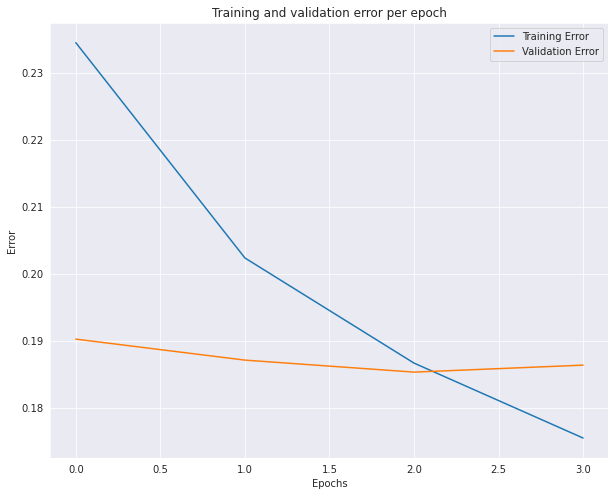

In [13]:
#checkpoint_losses_train, checkpoint_losses_val
x_epochs = []
for i in range(0, len(checkpoint_losses[0])): x_epochs.append(i)


# plotting the points  
#plt.plot(checkpoint_losses_train, y) 
plt.figure(figsize=(10, 8))
plt.plot(x_epochs, checkpoint_losses[0], label="Training Error")  
plt.plot(x_epochs, checkpoint_losses[1], label="Validation Error") 

# naming the x axis 
plt.xlabel('Epochs') 
# naming the y axis 
plt.ylabel('Error') 
    
# giving a title to my graph 
plt.title('Training and validation error per epoch') 
plt.legend(loc=1, )
# function to show the plot 
plt.show() 

# 5) Final Evaluation

After training, the accuracies of each label are calculated in the testing phase. </br>
As can be seen, the learning performance varies for each topping, but all are greater than 86%. Therefore, it can be concluded that the learning of the implemented neural network is satisfactory.

In [14]:
# create the per
perf_label_test = np.zeros((1,13))

# tell not to reserve memory space for gradients (much faster)
with torch.no_grad():
    for inputs, targets in test_dataloader:

        inputs = inputs.to(device)
        targets = targets.to(device)

        # compute outputs
        outputs = model(inputs)
        outputs = torch.transpose(outputs, 1, 0)
        outputs = outputs.reshape([len(targets),13])

        for i in range(0,len(outputs)):
          outputs[i] = torch.round(outputs[i])

        outputs_np = outputs.cpu().detach().numpy()
        targets_np = targets.cpu().detach().numpy()

        # compute the predictions
        pred = (outputs_np > 0)

        # update the performance
        perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

# Prints the performance (per label)

oa_test = perf_label_test / len(test_dataloader.dataset)
print(oa_test)

[[0.88876831 0.98209441 0.9066739  0.89907759 0.90992946 0.93868692
  0.85675529 0.94465545 0.86869235 0.98046663 0.99511666 0.97666848
  0.99348888]]


#Showing detection accuraccy of each topping

In [15]:
topping = ['Pepperoni', 'Bacon', 'Mushrooms', 'Onions', 'Peppers', 'Black olives', 'Tomatoes', 'Spinach', 'Fresh basil', 'Arugula', 'Broccoli', 'Corn', 'Pineapple']
def what_is_my_topping(output):
  str = ""
  for i in range(0, len(output)):
    if(output[i]):
      str = str + " " + topping[i]
  return str

def show_accuracies(acc):
  for i in range(0,len(acc[0])):
    print(topping[i]+ f" -> {acc[0][i]}")

show_accuracies(oa_test)

Pepperoni -> 0.8887683125339121
Bacon -> 0.9820944112859469
Mushrooms -> 0.9066739012479653
Onions -> 0.8990775908844275
Peppers -> 0.9099294628323386
Black olives -> 0.9386869234943027
Tomatoes -> 0.8567552902875746
Spinach -> 0.9446554530656538
Fresh basil -> 0.8686923494302767
Arugula -> 0.9804666304937601
Broccoli -> 0.99511665762344
Corn -> 0.9766684753119913
Pineapple -> 0.9934888768312534


### 4.4) Test analysis - images

Below, there are some test images and their respective labels decoded to show what toppings are in the pizza, that the neural network predicted. </br>
For example, in the first pizza, fresh basil was identified. In the last one mushrooms were identified.

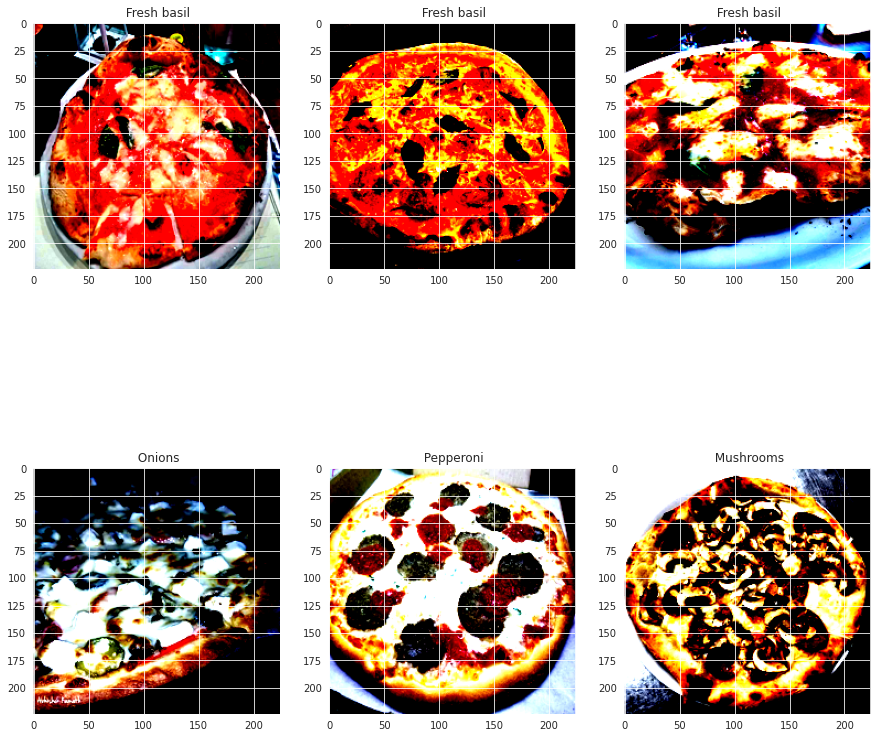

In [16]:
for inputs, targets in test_dataloader:
  inputs, targets = inputs.to(device),targets.to(device)
  outputs = model(inputs)
  outputs = torch.transpose(outputs, 1, 0)
  outputs = outputs.reshape([len(targets),13])

  f, axarr = plt.subplots(2,3, figsize=(15, 15))
  c = 0
  for i in range(2):
    for j in range(3):
      axarr[i][j].imshow(np.clip(np.array(inputs[c].cpu()).transpose(1,2,0), 0, 1), )
      axarr[i][j].set_title(what_is_my_topping(np.array(outputs[c].cpu().detach()).round()))
      c = c + 1  
  break

# 6) Comparison between Real and Synthetic datasets

After coding and solving the problem for the synthetic dataset, we adapted our code to work with the real dataset. The main changes were:
- Changing the last layer of the network to have 13 outputs instead of 10, since the real dataset has 13 possible toppings. This was a simple task as the last layer of the network was already custom-made by our previous work.
- The real dataset was organized in one block of data instead of a test and training sets. So, we loaded all the data and used the function train_test_split in a ratio of 80/20 to training and test sets respectively. It is also important to note that the training set has been also split during the training phase for validation purposes as it was done for the synthetic database.
- Another observation is that there were several images in the real dataset, around 50 located in the interval 3000-4000, that had 4 layers instead of the usual 3 (RGB), so they were treated as to ignore this last layer (transparency layer).
- As the images of the synthetic pizzas are simple, they are better treated and, thus, the performance with the synthetic dataset is better than the real dataset.